## Summary


GAMENet is a model that focuses on drug recommendation. However, instead of purely finding the optimal drugs to recommend based on a patient, GAMENet also uses EHR and Drug-to-Drug interaction knowledge graphs to tailor its recommendations based on potential adverse drug-to-drug interactions that may occur. The model uses these knowledge graphs as well as a dynamic memory module to augment its input with additional information to reduce adverse drug interactions while still allowing for accurate recommendations.

In our paper, we wanted to reproduce the model's results for GAMENet, with and without DDI. Additionally, we wanted to determine whether or not the Dynamic memory module played a significant role in the predictive task. Lastly, we wanted to see if there was any loss or gain in the effectiveness of the model if we replaced the knowledge graphs' implementation from a GCN with a GAT.

We were not able to completely reproduce the model's metrics, even after matching the Python and Library versions precisely. Our model had a worse DDI Rate but carried a slight improvement in all predictive metrics. This was consistent with DDI and without.
Removing the dynamic memory caused a significant increase in DDI Rate and a reduction in the predictive metrics.

Finally, replacing the GCN with a GAT slightly increased the DDI Rate but resulted in notable increases in the predictive metrics.

# Exploratory Analysis

First we need to gather preliminary statistics about the data. We will be using PyHealth to do so.

#### Note: Below we don't use the MIMIC-III data straight, as we don't want to expose it in our public repo. Instead we will use synthetic data  but one can replace the URL with the actual data and run the same analysis.

In [1]:
from pyhealth.datasets import MIMIC3Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = MIMIC3Dataset(
        root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        tables=["DIAGNOSES_ICD", "PRESCRIPTIONS", "PROCEDURES_ICD"],
        code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
    )

In [3]:
dataset.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 49993
	- Number of visits: 52769
	- Number of visits per patient: 1.0555
	- Number of events per visit in DIAGNOSES_ICD: 9.1038
	- Number of events per visit in PRESCRIPTIONS: 32.9969
	- Number of events per visit in PROCEDURES_ICD: 3.2186



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 49993\n\t- Number of visits: 52769\n\t- Number of visits per patient: 1.0555\n\t- Number of events per visit in DIAGNOSES_ICD: 9.1038\n\t- Number of events per visit in PRESCRIPTIONS: 32.9969\n\t- Number of events per visit in PROCEDURES_ICD: 3.2186\n'

In [4]:
def gamenet_drug_task_mimic3(patient):
    
    samples = []
    for visit_idx in range(len(patient) - 1):
        visit = patient[visit_idx]
        
        diagnostic_code = visit.get_code_list(table="DIAGNOSES_ICD")
        procedure_code = visit.get_code_list(table="PROCEDURES_ICD")
        drug_code = visit.get_code_list(table="PRESCRIPTIONS")
        
        samples.append(
        {
            "patient_id": patient.patient_id,
            "visit_id": visit.visit_id,
            "ICD9_CODE": diagnostic_code,
            "NDC": drug_code,
            "PRO_CODE": procedure_code,
            "NDC_Len": len(drug_code)
        })
    
    return samples
    

In [5]:
gamenet_dataset = dataset.set_task(gamenet_drug_task_mimic3)

Generating samples for gamenet_drug_task_mimic3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 49993/49993 [00:00<00:00, 416007.84it/s]


In [6]:
gamenet_dataset.stat()

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: gamenet_drug_task_mimic3
	- Number of samples: 2776
	- Number of patients: 2339
	- Number of visits: 2776
	- Number of visits per patient: 1.1868
	- ICD9_CODE:
		- Number of ICD9_CODE per sample: 9.0865
		- Number of unique ICD9_CODE: 2650
		- Distribution of ICD9_CODE (Top-10): [('4019', 972), ('41401', 624), ('42731', 597), ('25000', 544), ('4280', 523), ('2724', 360), ('5849', 328), ('53081', 326), ('2720', 308), ('5990', 300)]
	- NDC:
		- Number of NDC per sample: 18.8015
		- Number of unique NDC: 181
		- Distribution of NDC (Top-10): [('B05X', 1881), ('A06A', 1748), ('N02A', 1652), ('N02B', 1640), ('A02B', 1628), ('B01A', 1614), ('C07A', 1452), ('V06D', 1448), ('A12B', 1255), ('V04C', 1192)]
	- PRO_CODE:
		- Number of PRO_CODE per sample: 3.2385
		- Number of unique PRO_CODE: 817
		- Distribution of PRO_CODE (Top-10): [('3893', 458), ('3961', 426), ('9904', 393), ('8856', 253), ('3615', 235), ('9604', 222), ('966', 2

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: gamenet_drug_task_mimic3\n\t- Number of samples: 2776\n\t- Number of patients: 2339\n\t- Number of visits: 2776\n\t- Number of visits per patient: 1.1868\n\t- ICD9_CODE:\n\t\t- Number of ICD9_CODE per sample: 9.0865\n\t\t- Number of unique ICD9_CODE: 2650\n\t\t- Distribution of ICD9_CODE (Top-10): [('4019', 972), ('41401', 624), ('42731', 597), ('25000', 544), ('4280', 523), ('2724', 360), ('5849', 328), ('53081', 326), ('2720', 308), ('5990', 300)]\n\t- NDC:\n\t\t- Number of NDC per sample: 18.8015\n\t\t- Number of unique NDC: 181\n\t\t- Distribution of NDC (Top-10): [('B05X', 1881), ('A06A', 1748), ('N02A', 1652), ('N02B', 1640), ('A02B', 1628), ('B01A', 1614), ('C07A', 1452), ('V06D', 1448), ('A12B', 1255), ('V04C', 1192)]\n\t- PRO_CODE:\n\t\t- Number of PRO_CODE per sample: 3.2385\n\t\t- Number of unique PRO_CODE: 817\n\t\t- Distribution of PRO_CODE (Top-10): [('3893', 458), ('3961', 426), ('9904', 393), ('8856',

Above is the exploratory stats for the MIMIC 3 dataset. The results differ slightly from the paper, this may be due to differences in the underlying dataset used. The paper only references a pickled version of the data and doesn't point directly to the main underlying data. None the less, for initial exploration, this will do.

In [7]:
gamenet_df = pd.DataFrame(list(gamenet_dataset))
gamenet_df.head()

,patient_id,visit_id,ICD9_CODE,NDC,PRO_CODE,NDC_Len
0,10009,110342,"[5789, 2724, 45620, 78659, 45981, 81601, 5848]","[A02B, N02A, B01A, A04A, A12B, A06A, N06A]",[4516],7
1,10024,110358,"[51881, 4280, 42731, 41401, 496, 2867, 41091, ...","[V06D, C01C, N01A, A12A, C10A, A06A, J01X, N02...","[9672, 3961, 8856, 3404, 0013, 3749]",31
2,10025,110360,"[2720, 5070, 42731, 41401, V4581, 5119, 43820,...","[N06D, H02A, N02B, B01A, N04A, C10A, G04C, A10B]",[3521],8
3,10051,110387,"[4019, 25000, 2449, 1985, 27730, V1042, 80326]","[N02A, A12B, B05B, B05X]",[],4
4,10092,110429,"[53081, 5715, 5185, 5180, 1623, 5672, 8748, 78...","[A06A, N02A, B01A, A04A, C09A]",[3409],5


The below heatmap indicates that there are some strong correlations between some diagnostic codes and recommended drugs. This can indicate the dataset is good to use with the gamenet model, where it can learn the predictive task.

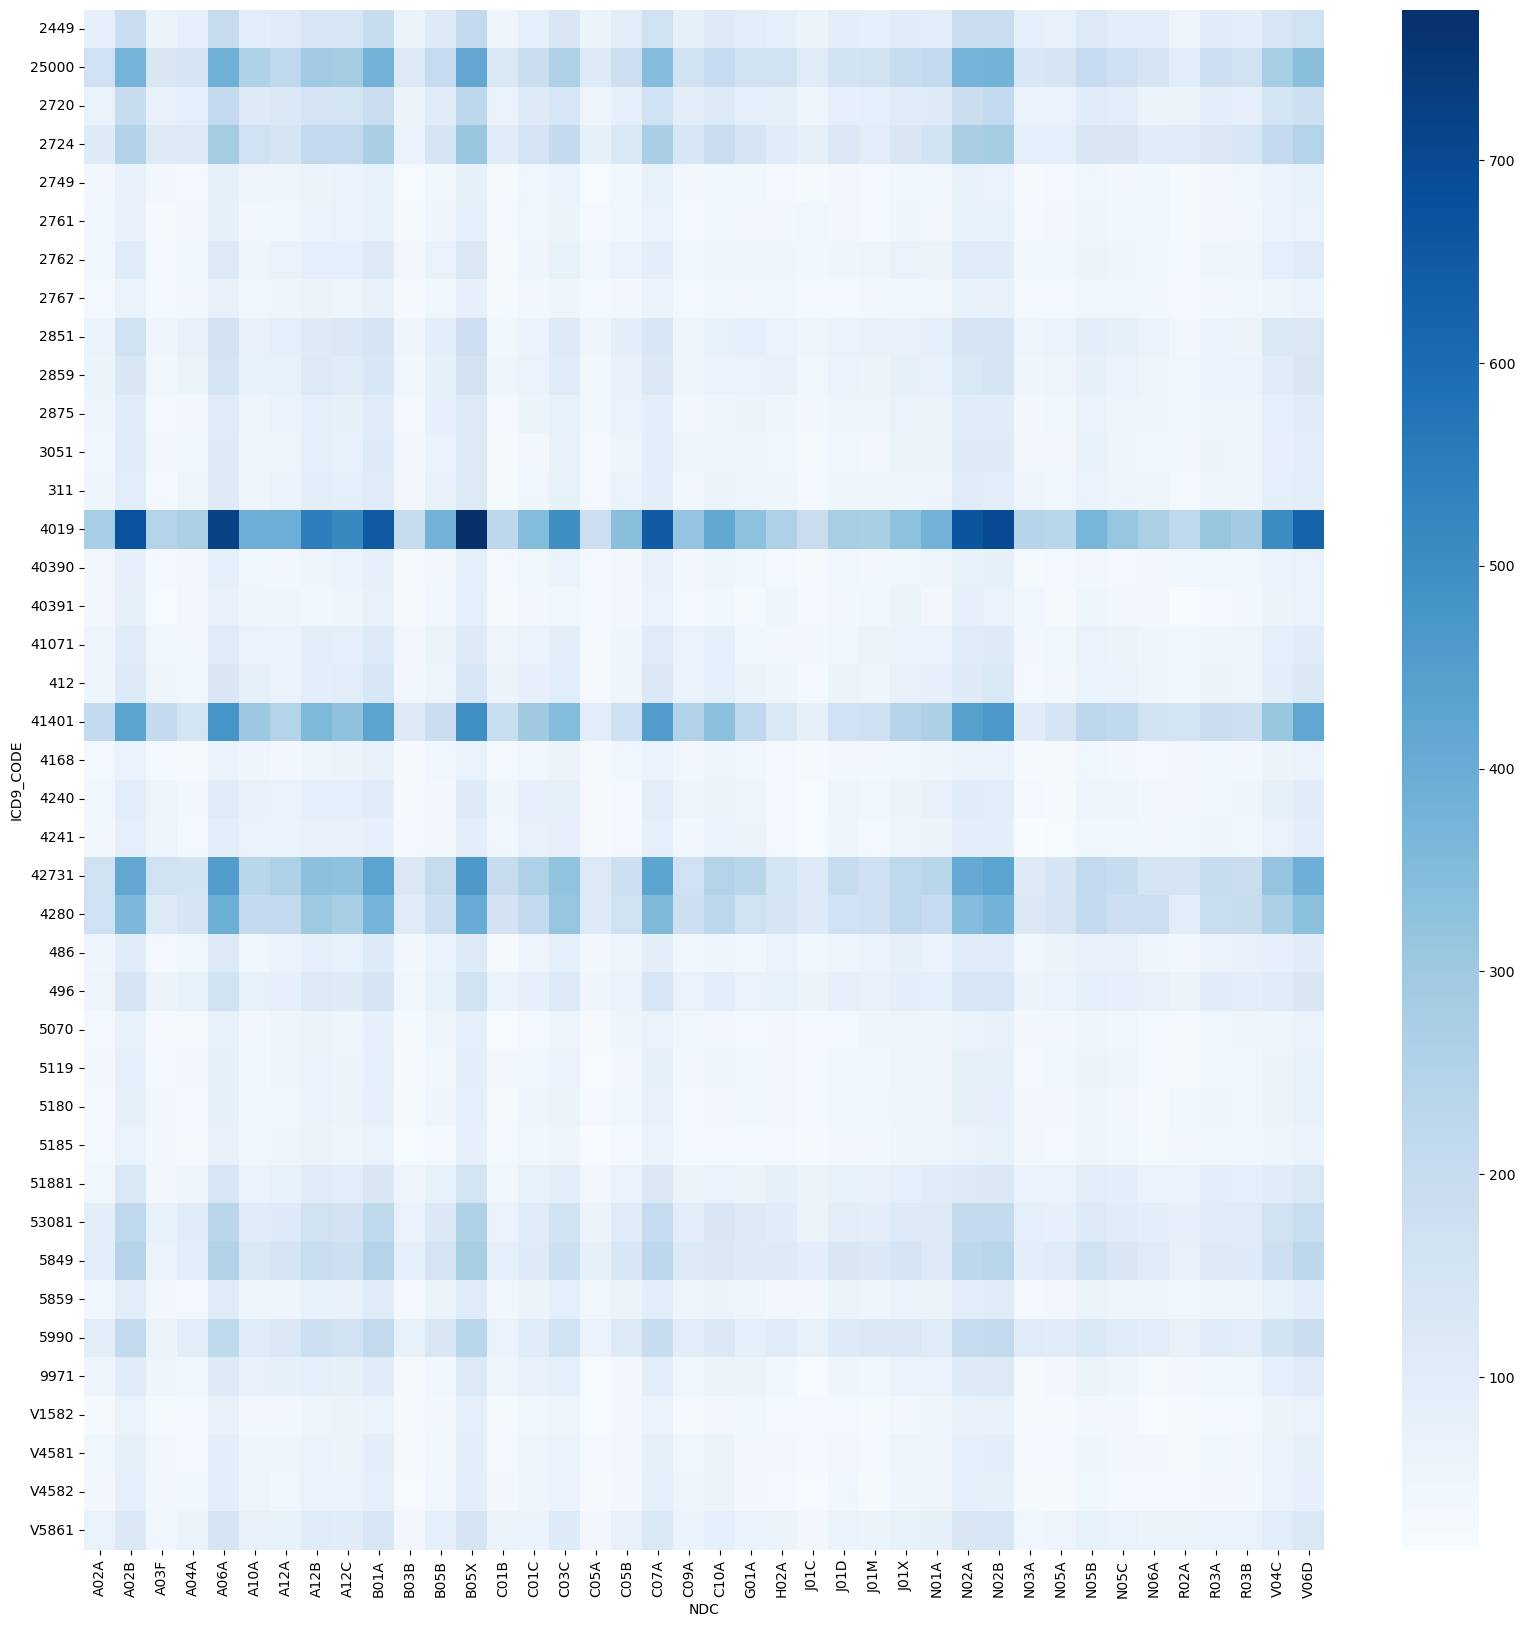

In [8]:
df_grouped = gamenet_df.explode('ICD9_CODE').explode('NDC').groupby(['ICD9_CODE', 'NDC']).size().reset_index(name='count')
total_icd9_counts = df_grouped.groupby('ICD9_CODE')['count'].sum().reset_index(name='total_count')
sorted_icd9_codes = total_icd9_counts.sort_values('total_count', ascending=False)['ICD9_CODE'].tolist()[:40]
total_ndc_counts = df_grouped.groupby('NDC')['count'].sum().reset_index(name='total_count')
sorted_ndc_codes = total_ndc_counts.sort_values('total_count', ascending=False)['NDC'].tolist()[:40]
pivot_df = df_grouped[(df_grouped['ICD9_CODE'].isin(sorted_icd9_codes)) & (df_grouped['NDC'].isin(sorted_ndc_codes))].pivot(index='ICD9_CODE', columns='NDC', values='count')

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(pivot_df, cmap='Blues')
plt.show()

## Methodology explanation and examples

We run the repo's original code for the following models.
- GAMENet without DDI
- GAMENET with DDI

Afterwards, in order to test the effectiveness of the DM module in the model, we altered the code for the DM input. Specifically, we allow for two alterations to the inpout.

1) Remove it completely,
2) Zero it out.

We can import the updated model, and by altering the code a bit, we can test it out and see the results. The models have been pretrained, so here we will test out their effectiveness with our data. We will also used the pickled and clean data in the repository. This will allow us to closely mimic the author's original setup

In [9]:
from gamenet_main import main

First we will evaluate the GAMENet model without DDI.

Next we compare the above result with the DDI module

In [10]:
gamenet_without_ddi_results = main(cpu=False, isTest=True, withDDI=False, graph_type='GCN', remove_dm=None, resume_name='pretrained/gcn/noddi.model')

parameters 452434

Eval--Epoch: 0, Step: 1057/1058	DDI Rate: 0.0867, Jaccard: 0.4499,  PRAUC: 0.6906, AVG_PRC: 0.6254, AVG_RECALL: 0.6249, AVG_F1: 0.6075


In [11]:
gamenet_with_ddi = main(cpu=False, isTest=True, withDDI=True, graph_type='GCN', remove_dm=None, resume_name='pretrained/gcn/ddi.model')

parameters 452434

Eval--Epoch: 0, Step: 1057/1058	DDI Rate: 0.0791, Jaccard: 0.4523,  PRAUC: 0.6910, AVG_PRC: 0.6286, AVG_RECALL: 0.6258, AVG_F1: 0.6093


The relative results of the two are quite similar to the papers. When running with an identical PyTorch version, we can results which are quite close to the original paper's.

So far, we have reproduced the paper's results in terms of  DDI Rate, Jacard, PR-AUC, and F1 score. We were successfully able to get similar results as the paper's, which was expected.

Now we will run the ablation study. We first test the effectiveness of the DM memory module. We can remove the Dynamic Memory module's input completely, reducing the dimensionality of the input vectors and losing all short term information.

In [12]:
gamenet_without_ddi_remove_input_results = \
    main(cpu=False, isTest=True, withDDI=False, graph_type='GCN', remove_dm='remove_input', resume_name='pretrained/gcn/noddi_remove_input.model')

parameters 444242

Eval--Epoch: 0, Step: 1057/1058	DDI Rate: 0.0843, Jaccard: 0.4452,  PRAUC: 0.6855, AVG_PRC: 0.6176, AVG_RECALL: 0.6268, AVG_F1: 0.6030


In [13]:
gamenet_with_ddi_remove_input_results = \
    main(cpu=False, isTest=True, withDDI=True, graph_type='GCN', remove_dm='remove_input', resume_name='pretrained/gcn/ddi_remove_input.model')

parameters 444242

Eval--Epoch: 0, Step: 1057/1058	DDI Rate: 0.0851, Jaccard: 0.4458,  PRAUC: 0.6901, AVG_PRC: 0.6232, AVG_RECALL: 0.6207, AVG_F1: 0.6035


We see above that the DDI Rate was greatly increased to their respective ablated models. And as expected the predictive scores reduce by a notable amount. This is expected to see.

Next we obsever that zeroing out the information still results in an increase in DDI Rate, and a reduction in predictive scores, but interestingly still outperforms removing the input entirely. This is odd since we would imagine that it would be the same, as the same level of information is lost in both processes.

In [14]:
gamenet_without_ddi_zero_input_results = \
    main(cpu=False, isTest=True, withDDI=False, graph_type='GCN', remove_dm='zero_input', resume_name='pretrained/gcn/noddi_zero_input.model')

parameters 452434

Eval--Epoch: 0, Step: 1057/1058	DDI Rate: 0.0804, Jaccard: 0.4483,  PRAUC: 0.6894, AVG_PRC: 0.6280, AVG_RECALL: 0.6217, AVG_F1: 0.6061


In [15]:
gamenet_with_ddi_zero_input_results = \
    main(cpu=False, isTest=True, withDDI=True, graph_type='GCN', remove_dm='zero_input', resume_name='pretrained/gcn/ddi_zero_input.model')

parameters 452434

Eval--Epoch: 0, Step: 1057/1058	DDI Rate: 0.0849, Jaccard: 0.4495,  PRAUC: 0.6909, AVG_PRC: 0.6301, AVG_RECALL: 0.6201, AVG_F1: 0.6070


Lastly, we will replace the GCN network used in GAMENet with a GAT. GAT's allow for weighted attentions which could allow the model to better focus on important drug-to-drug interactions, versus the more general approach from GATs.

gamenet_without_ddi_results = main(cpu=False, isTest=True, withDDI=False, graph_type='GAT', remove_dm=None, resume_name='pretrained/gat/noddi.model')

In [16]:
gamenet_with_ddi = main(cpu=False, isTest=True, withDDI=True, graph_type='GAT', remove_dm=None, resume_name='pretrained/gat/ddi.model')

parameters 641746

Eval--Epoch: 0, Step: 1057/1058	DDI Rate: 0.0794, Jaccard: 0.4560,  PRAUC: 0.6953, AVG_PRC: 0.6307, AVG_RECALL: 0.6336, AVG_F1: 0.6133


Interestingly, without the DDI module, GAT did better as it allows for more attention to certain areas of the EHR knowledge graph. The DDI rate and most predictive metrics improved.

However, with the DDI module, we see that the DDI Rate increase by approximately 0.0003. This is strange since we would expect the GAT to allow for a more focus understanding of the DDI interaction knowledge graph. However, the model may have just accepted this small increase to allow for far better predictive metrics. All predictive metrics were substantially increased.

## Illustration of Results

Below you can see a summary of our results.

In [17]:
results = pd.read_csv('../results.csv').set_index('Methods')
results

,DDI Rate,△ DDI Rate %,Jaccard,PR-AUC,F1
Methods,,,,,
Nearest (from ours),0.0791,+1.80%,0.3911,0.3805,0.5465
RETAIN (from ours),0.0829,+6.69%,0.4175,0.6644,0.5789
GameNet (w/o DDI from ours),0.0867,+11.58%,0.4499,0.6906,0.6075
GameNet (from ours),0.0791,+1.80%,0.4523,0.6910,0.6093
GameNet (w/o DDI & DM by Zero Input),0.0804,+3.47%,0.4483,0.6894,0.6061
GameNet (w/o DDI & DM by Remove Input),0.0843,+8.49%,0.4452,0.6855,0.6030
GameNet (w/o DM by Zero Input),0.0849,+9.27%,0.4495,0.6909,0.6070
GameNet (w/o DM by Remove Input),0.0851,+9.52%,0.4458,0.6901,0.6035
GameNet (w/o DDI & GAT),0.0856,+10.17%,0.4504,0.6883,0.6081


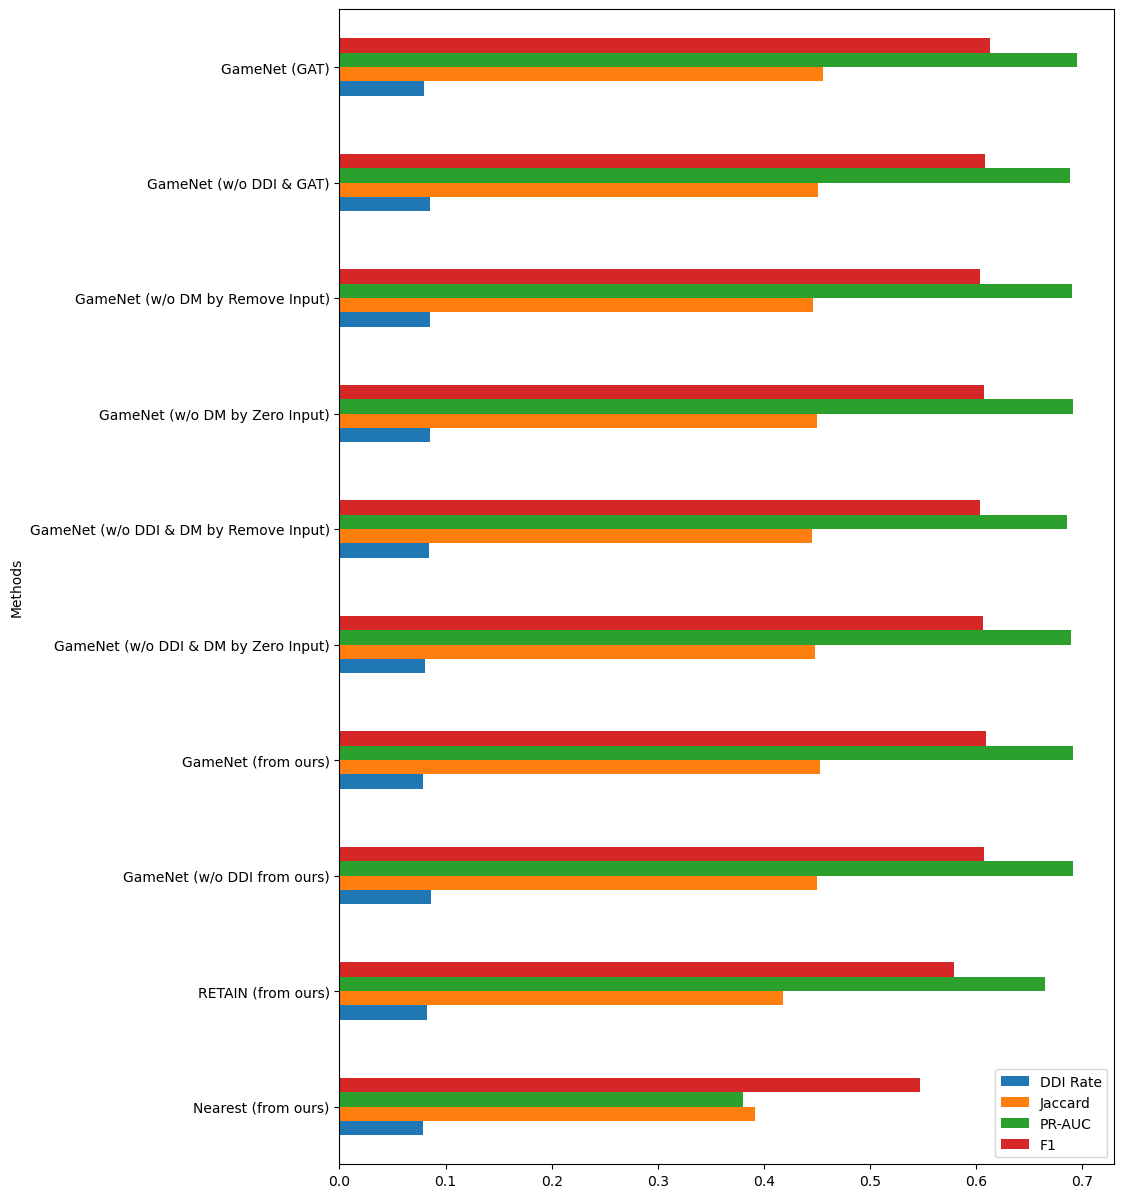

In [18]:
fig, ax = plt.subplots(figsize=(10, 15))
ax = results.plot.barh(ax=ax)
plt.show()

As the plot above clearly illustrates, when it comes to predictive metrics, GAMENet exceeds the other models regardless of the ablation done. Across GAMENet models, the predictive metrics are mostly the same, however a closer inspection of DDI rate displays there is quite a bit difference.

DDI Rate with GAT and GCN are quite lower than the others.

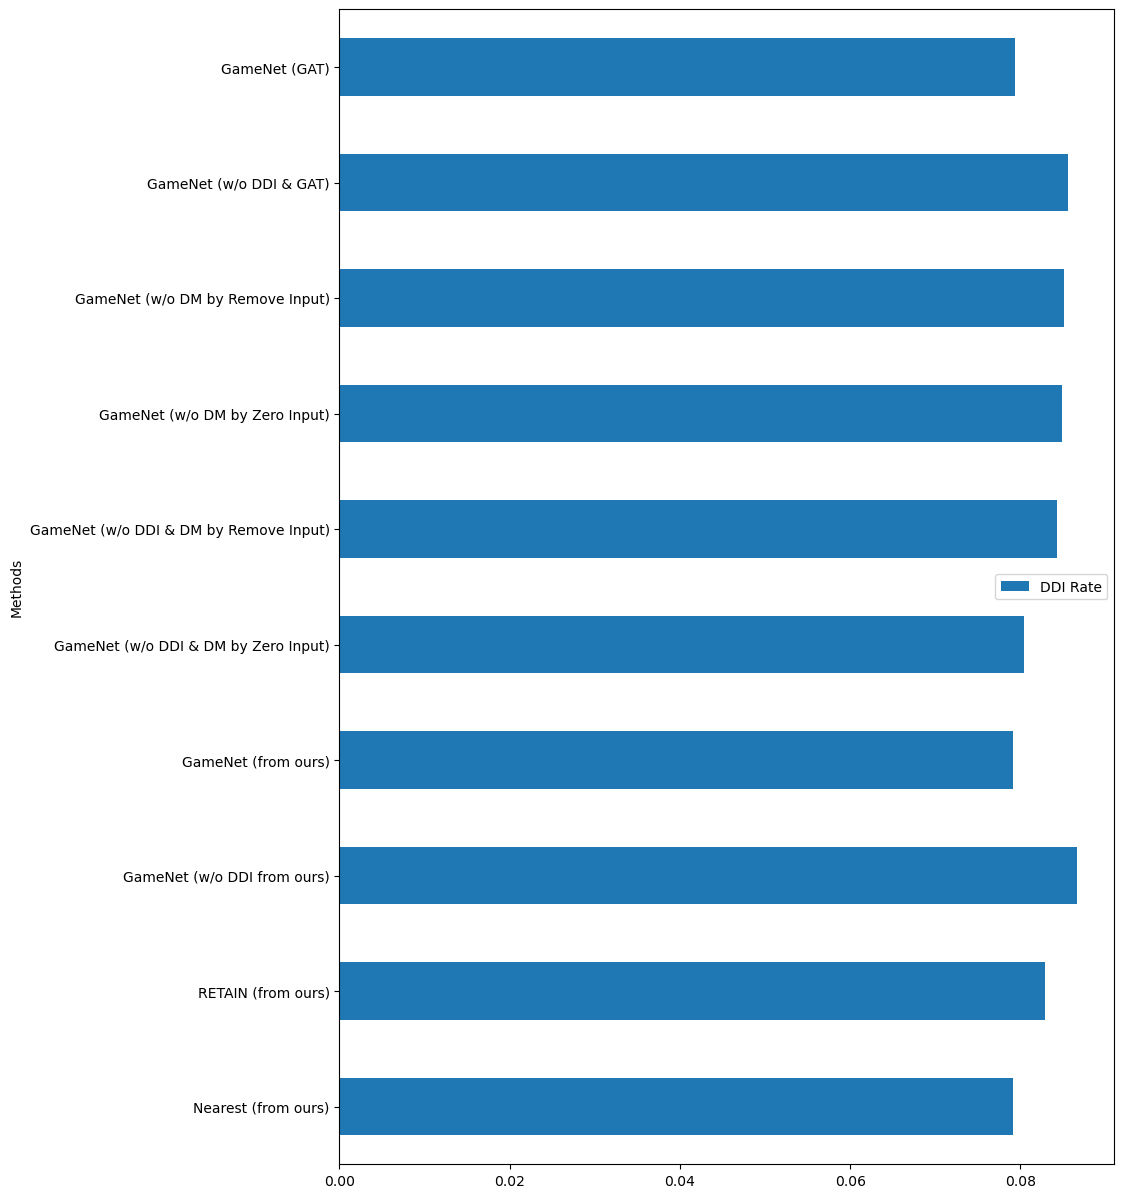

In [19]:
fig, ax = plt.subplots(figsize=(10, 15))
ax = results[['DDI Rate']].plot.barh(ax=ax)
plt.show()

# References


-2013. Ten simple rules for reproducible computational
research. PLOS Computational Biology, 9(10).

Lu Shen Li-Wei H Lehman Mengling Feng Moham-
mad Ghassemi Benjamin Moody Peter Szolovits Leo
Anthony Celi Roger G Mark Alistair E W Johnson,
Tom J Pollard. 2016. MIMIC-III, a freely accessible
critical care database. Scientific data 3:160035.

Carl Boettiger. 2015. An introduction to docker for
reproducible research. ACM SIGOPS Operating Sys-
tems Review, 49(1):71–79.

Joshua A. Kulas Andy Schuetz-Walter F. Stewart Ji-
meng Sun Edward Choi, Mohammad Taha Bahadori.
2016. RETAIN: An Interpretable Predictive Model
for Healthcare using Reverse Time Attention Mecha-
nism. arXiv preprint arXiv:1608.05745.

Daniel Riley Fay, Ali Sazegari, and Daniel A. Connors.
2006. A detailed study of the numerical accuracy of
gpu-implemented math functions.

Roxana Daneshjou Russ B. Altman Nicholas
P. Tatonetti, Patrick P. Ye. 2012. Data-driven
prediction of drug effects and interactions. Science
translational medicine 4(125):125ra31–125ra31.

Junyuan Shang, Cao Xiao, Tengfei Ma, Hongyan Li, and
Jimeng Sun. 2018. GAMENet: Graph Augmented
MEmory Networks for Recommending Medication
Combination. arXiv preprint arXiv:1809.01852.

Petar Veli ˇckovi  ́c, Guillem Cucurull, Arantxa Casanova,
Adriana Romero, Pietro Li `o, and Yoshua Bengio.
2018. Graph Attention Networks. International Con-
ference on Learning Representations. Accepted as
poster.

Devon Yablonski. 2011. Numerical accuracy differ-
ences in cpu and gpgpu codes.

PyHealth. pyhealth.datasets.MIMIC3Dataset. 2021. Available at: https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC3Dataset.html. Accessed on: 2023-04-28.